In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

# Mounting and Installation of Package: Only on Google Colab

# Library Imports

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special

# Data Generation

Data are generated as:
\begin{align}
x[1:] \sim~& U[-1, 1]^{d-1}\\
x[0] \sim~& Binomial(1, .5 + .3 \cdot g(x))\\
y \sim~& x[0] + g(x) + N(0, 1)
\end{align}
We consider several non-linear functions $g$. We then want to learn some average moment $E[m(x, y; f)]$ of the regression function 
\begin{equation}
f(x) = E[y\mid x] = x[0] + g(x).
\end{equation}

In [3]:
def nonlin(x):
    # return 1.5 * (x[:, 1]**2)
    # return x[:, 1]
    # return scipy.special.expit(10 * x[:, 1])
    return np.abs(x[:, 1])
    # return 1.5*scipy.special.expit(10 * x[:, 1]) - 1.5*scipy.special.expit(10 * x[:, 2])

def true_propensity(X):
    return .5 + .3 * nonlin(X)

def true_f(X):
    return X[:, 0] + nonlin(X)

def gen_data(n, p, treatment='binary'):
    X = np.random.uniform(-1, 1, size=(n, p))
    if treatment == 'binary':
        X[:, 0] = np.random.binomial(1, true_propensity(X))
    else:
        X[:, 0] = true_propensity(X) + np.random.normal(size=(n,))
    y = true_f(X) + np.random.normal(size=(n,))
    return X, y

np.random.seed(123)
treatment = 'binary'
# treatment = 'continuous'
n = 2000
p = 3
X, y = gen_data(n, p, treatment)
X_test, y_test = gen_data(n, p, treatment)

# Moment Definition

### ATE Moment

In [6]:
def moment_fn(x, test_fn):
    t1 = test_fn(np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]]))
    t0 = test_fn(np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]]))
    return t1 - t0

def true_reisz(x, propensity):
    return (x[:, 0]==1) / propensity(x) - (x[:, 0]==0)/(1 - propensity(x))

### Policy Moment

In [8]:
policy = lambda x: scipy.special.expit(10*x[:, 1])

def moment_fn(x, test_fn):
    t1 = test_fn(np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]]))
    t0 = test_fn(np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]]))
    p1 = policy(x)
    if len(t1.shape) > 1:
        p1 = p1.reshape(-1, 1)
    return t1 * p1 + t0 * (1 - p1) 

def true_reisz(x, propensity):
    p1 = policy(x)
    prop1 = propensity(x)
    return p1 * (x[:, 0]==1) / prop1 + (1 - p1) * (x[:, 0]==0)/(1 - prop1)

### X-Transportation

The true Reisz is more complex here due to the correlation of T=X[:, 0] and X[:, 1]. We have, let $t=X[:, 0]$ and $x=X[:, 1]$. Then the relevant ratios are:
\begin{align}
\frac{f_{trans}(t, x)}{f(t, x)} = \frac{Pr[T=t|X=t^{-1}(x)] f(t^{-1}(x)) (t^{-1}(x))'}{Pr[T=t|X=x] f(x)} 
\end{align}
When $x$ is drawn from the uniform distribution, then the density if constant and the above simplifies to:
\begin{align}
\frac{f_{trans}(t, x)}{f(t, x)}= \frac{Pr[T=t|X=t^{-1}(x)] (t^{-1}(x))'}{Pr[T=t|X=x]}
\end{align}

In [ ]:
trans = lambda x: (1 + x)**(1/2)/2**(1/2)
invtrans = lambda u: 2 * (u**2) - 1
grad_invtrans = lambda u: 4 * u

def moment_fn(x, test_fn):
    tx =  np.hstack([x[:, [0]], trans(x[:, [1]]), x[:, 2:]])
    return test_fn(tx) - test_fn(x)

def true_reisz(x, propensity=None):
    invtx = np.hstack([x[:, [0]], invtrans(x[:, [1]]), x[:, 2:]])
    out0 = np.clip(propensity(invtx) * grad_invtrans(x[:, 1]) / propensity(x), 0, np.inf)
    out1 = np.clip((1 - propensity(invtx)) * grad_invtrans(x[:, 1]) / (1 - propensity(x)), 0, np.inf)
    return out0 * x[:, 0] + out1 * (1 - x[:, 0]) - 1

# Adversarial Reisz Estimator

In [8]:
from advreisz.linear import SparseLinearAdvRiesz
from advreisz.linear.utilities import SeparateFeaturizer, CoordinatePolynomialFeatures

In [9]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.pipeline import Pipeline

# feat = Pipeline([('p', CoordinatePolynomialFeatures(degree=3))])
feat = Pipeline([('p', PolynomialFeatures(degree=4, include_bias=False))])
# feat = Pipeline([('nys', Nystroem(n_components=100, kernel='rbf', gamma=5, degree=3))])
# feat = Pipeline([('nys', RBFSampler(n_components=100, gamma=2))])
feat.steps.append(('s', StandardScaler()))
feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
# feat = Pipeline([('p', SeparateFeaturizer(feat))])
# feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                             n_iter=50000, lambda_theta=0.01, B=10,
                             tol=0.00001).fit(X)

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "


In [10]:
coefs = splin.coef
print("Maximum violation: ", splin.max_violation_)
#print("Estimated non-zero coefs: ", np.array(list(zip(splin.get_feature_names(), coefs))))
print("Min/Max: ", splin.min_response_loss_, splin.max_response_loss_)
print("Dualit Gap: ", splin.duality_gap_)
print("Iters: ", splin.n_iters_)

Maximum violation:  0.0022255036847077846
Min/Max:  0.04954122072356301 0.0502912620421217
Dualit Gap:  0.0007500413185586863
Iters:  50000


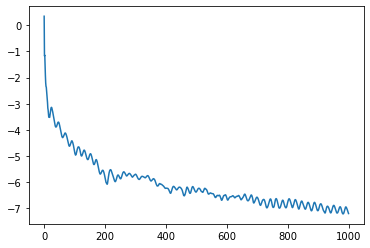

In [11]:
plt.plot(np.log(np.array(splin.duality_gaps)))
plt.show()

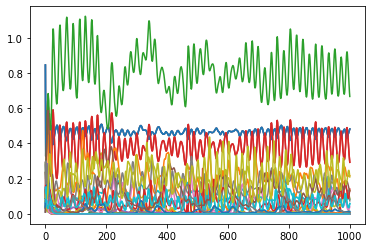

In [12]:
plt.plot(np.exp(np.array(splin.log_theta_list)))
plt.show()

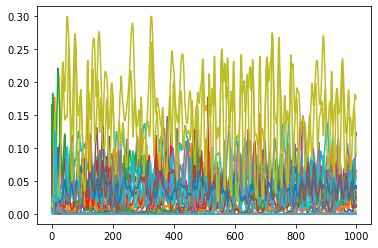

In [13]:
plt.plot(np.exp(np.array(splin.log_w_list)))
plt.show()

# Evaluation of Learned Reisz Representer

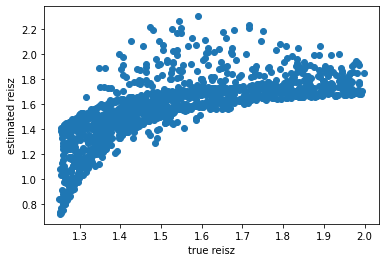

In [14]:
if treatment == 'binary': 
    plt.figure()
    treated = (X_test[:, 0] == 1)
    plt.scatter(true_reisz(X_test[treated], true_propensity), splin.predict(X_test[treated]))
    plt.xlabel('true reisz')
    plt.ylabel('estimated reisz')
    plt.show()

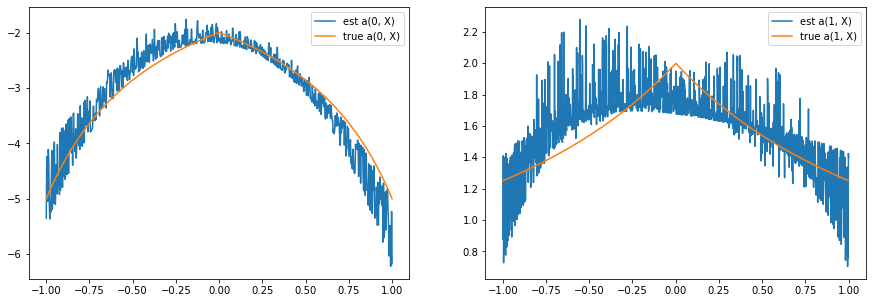

In [15]:
if treatment == 'binary': 
    plt.figure(figsize=(15, 5))
    error = true_reisz(X_test, true_propensity) - splin.predict(X_test)
    plt.title("RMSE: {:.3f}, MAE: {:.3f}".format(np.sqrt(np.mean(error**2)), np.mean(np.abs(error))))
    for t in [0, 1]:
        plt.subplot(1, 2, t + 1)
        treated = (X_test[:, 0] == t)
        Xtreated = X_test[treated].copy()
        Xtreated[:, 1] = np.linspace(-1, 1, Xtreated.shape[0])
        plt.plot(Xtreated[:, 1], splin.predict(Xtreated), label='est a({}, X)'.format(t))
        plt.plot(Xtreated[:, 1], true_reisz(Xtreated, true_propensity), label='true a({}, X)'.format(t))
        plt.legend()
    plt.show()

# Debiased Average Moment Estimate

Applying the learned Reisz representer in order to debias a preliminary regression based model of the ATE

In [16]:
def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [17]:
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline

est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
if treatment == 'binary':
    propensity = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', LogisticRegressionCV())]).fit(X[:, 1:], X[:, 0])

In [18]:
a_test = splin.predict(X_test)
true_ate = np.mean(moment_fn(X_test, true_f))
biased_ate = np.mean(moment_fn(X_test, est.predict))
reisz_ate = np.mean(a_test * y_test)
dr_reisz_ate, dr_reisz_low, dr_reisz_up = mean_ci(moment_fn(X_test, est.predict) + a_test * (y_test - est.predict(X_test)))
if treatment == 'binary':
    naive_ate = np.mean(y_test[X_test[:, 0]==1]) - np.mean(y_test[X_test[:, 0]==0])
    invp_test = true_reisz(X_test, lambda x: propensity.predict_proba(x[:, 1:])[:, 1])
    ips_ate = np.mean(invp_test * y_test)
    dr_ate = biased_ate + np.mean(invp_test * (y_test - est.predict(X_test)))

In [19]:
print("True ATE: {:.3f}".format(true_ate))
print("Lasso Regression based Estimate: {:.3f}".format(biased_ate))
print("IPS estimate with adversarial reisz: {:.3f}".format(reisz_ate))
print("DR estimate with adversarial reisz: {:.3f} ({:.3f}, {:.3f})".format(dr_reisz_ate, dr_reisz_low, dr_reisz_up))
if treatment == 'binary':
    print("Mean of Treated - Mean of Untreated: {:.3f}".format(naive_ate))
    print("IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): {:.3f}".format(ips_ate))
    print("DR estimate with explict propensity based reisz estimate: {:.3f}".format(dr_ate))

True ATE: 1.000
Lasso Regression based Estimate: 0.701
IPS estimate with adversarial reisz: 0.991
DR estimate with adversarial reisz: 0.931 (0.834, 1.027)
Mean of Treated - Mean of Untreated: 1.039
IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): 1.090
DR estimate with explict propensity based reisz estimate: 1.035


In [20]:
dr_reisz_ate = []
reisz_ate = []
biased_ate = []
dr_reisz_cov = []
reisz_cov = []
for exp in range(1000):
    Xboot, yboot = gen_data(n, p, treatment)
    aboot = splin.predict(Xboot)
    drm, drl, dru = mean_ci(moment_fn(Xboot, est.predict) + aboot * (yboot - est.predict(Xboot)))
    rm, rl, ru = mean_ci(aboot * yboot)
    dr_reisz_ate.append(drm)
    reisz_ate.append(rm)
    dr_reisz_cov.append((true_ate <= dru) & (true_ate >= drl))
    reisz_cov.append((true_ate <= ru) & (true_ate >= rl))

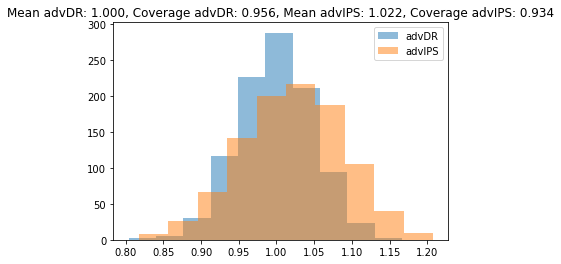

In [21]:
plt.title("Mean advDR: {:.3f}, Coverage advDR: {:.3f}, "
          "Mean advIPS: {:.3f}, Coverage advIPS: {:.3f}".format(np.mean(dr_reisz_ate),
                                                               np.mean(dr_reisz_cov),
                                                               np.mean(reisz_ate),
                                                               np.mean(reisz_cov)))
plt.hist(np.array(dr_reisz_ate), alpha=.5, label='advDR')
plt.hist(np.array(reisz_ate), alpha=.5, label='advIPS')
plt.legend()
plt.show()

In [22]:
import pandas as pd

df = pd.read_csv('rahul/sim_1.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values

In [23]:
feat = Pipeline([('p', PolynomialFeatures(degree=3, include_bias=False))])
feat.steps.append(('s', StandardScaler()))
feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                             n_iter=50000, lambda_theta=0.01, B=10,
                             tol=0.00001).fit(X)

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "


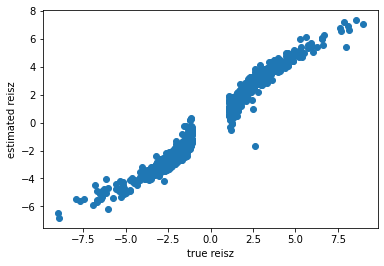

In [24]:
plt.figure()
treated = (X_test[:, 0] == 1)
plt.scatter(df['rr'].values, splin.predict(X))
plt.xlabel('true reisz')
plt.ylabel('estimated reisz')
plt.show()

In [25]:
a_test = splin.predict(X)
est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
dr_reisz_ate, dr_reisz_low, dr_reisz_up = mean_ci(moment_fn(X, est.predict) + a_test * (y - est.predict(X)))

In [26]:
dr_reisz_ate, dr_reisz_low, dr_reisz_up 

(2.171419091455974, 2.047085448705302, 2.2957527342066464)

In [27]:
import pandas as pd
from joblib import Parallel, delayed

def exp(it):
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    feat = Pipeline([('p', PolynomialFeatures(degree=2, include_bias=False))])
    feat.steps.append(('s', StandardScaler()))
    feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
    splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                                n_iter=50000, lambda_theta=0.01, B=10,
                                tol=0.00001).fit(X)
    a_test = splin.predict(X)
    est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
    return mean_ci(moment_fn(X, est.predict) + a_test * (y - est.predict(X)))

true = 2.2

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it) for it in np.arange(1, 101).astype(int))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


In [41]:
results = np.array(results)

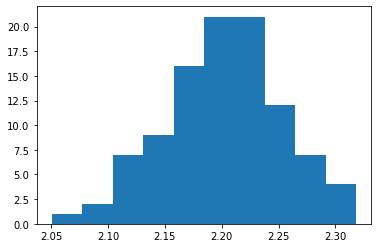

In [42]:
plt.hist(results[:, 0])
plt.show()

In [43]:
np.mean((results[:, 1] <= true) & (results[:, 2] >= true))

0.97

In [44]:
np.std(results[:, 0])

0.05116563577507155

In [37]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

def exp(it):
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    a_pred = np.zeros(X.shape[0])
    reg_pred = np.zeros(X.shape[0])
    moment_pred = np.zeros(X.shape[0])
    for train, test in KFold(n_splits=5).split(X):
        feat = Pipeline([('p', PolynomialFeatures(degree=2, include_bias=False))])
        feat.steps.append(('s', StandardScaler()))
        feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
        splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                                    n_iter=50000, lambda_theta=0.01, B=10,
                                    tol=0.00001).fit(X[train])
        a_pred[test] = splin.predict(X[test])
        est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X[train], y[train])
        reg_pred[test] = est.predict(X[test])
        moment_pred[test] = moment_fn(X[test], est.predict)

    return mean_ci(moment_pred + a_pred * (y - reg_pred))

true = 2.2

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it) for it in np.arange(1, 101).astype(int))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.2min finished


In [38]:
results

[(2.191435647676863, 2.073574705923437, 2.3092965894302893),
 (2.1305146431838056, 2.018052581496223, 2.242976704871388),
 (2.219959451148267, 2.1032463393826024, 2.3366725629139316),
 (2.149961546382838, 2.032403891135029, 2.267519201630647),
 (2.2173957717317943, 2.1021171221569883, 2.3326744213066),
 (2.2017445397281956, 2.090246502942006, 2.3132425765143854),
 (2.234246881126909, 2.1186426966807046, 2.3498510655731133),
 (2.318175629166912, 2.207465274639688, 2.428885983694136),
 (2.189459204931333, 2.079693488600682, 2.299224921261984),
 (2.190232408206474, 2.073390594803225, 2.3070742216097226),
 (2.156017007056618, 2.0405995003580117, 2.271434513755224),
 (2.315076729928765, 2.20341619591854, 2.42673726393899),
 (2.050554270862484, 1.9405333082048652, 2.160575233520103),
 (2.2495604811258207, 2.1378180843665544, 2.361302877885087),
 (2.120432161133421, 2.0065775161071397, 2.234286806159702),
 (2.262012965792037, 2.153060578036614, 2.3709653535474597),
 (2.166879517499674, 2.0536

In [4]:
def nonlin(x):
    # return 1.5 * (x[:, 1]**2)
    # return x[:, 1]
    # return scipy.special.expit(10 * x[:, 1])
    return np.abs(x[:, 1])
    # return 1.5*scipy.special.expit(10 * x[:, 1]) - 1.5*scipy.special.expit(10 * x[:, 2])

def true_propensity(X):
    return .5 * np.ones(X.shape[0])

def true_f(X):
    return X[:, 0] + nonlin(X)

def gen_data(n, p, treatment='binary'):
    X = np.random.uniform(-1, 1, size=(n, p))
    if treatment == 'binary':
        X[:, 0] = np.random.binomial(1, true_propensity(X))
    else:
        X[:, 0] = true_propensity(X) + np.random.normal(size=(n,))
    y = true_f(X) + np.random.normal(size=(n,))
    return X, y

np.random.seed(123)
treatment = 'binary'
# treatment = 'continuous'
n = 2000
p = 2
X, y = gen_data(n, p, treatment)
X_test, y_test = gen_data(n, p, treatment)

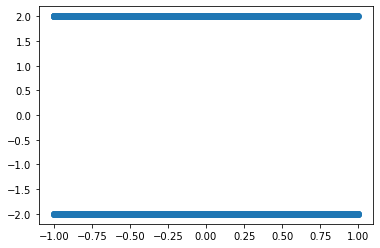

In [7]:
plt.scatter(X[:, 1], true_reisz(X, true_propensity))
plt.show()

In [21]:
import pandas as pd
df = pd.read_csv(f'rahul/sim_1.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values

In [22]:
Xtest = X.copy()

In [23]:
class AdvKernelReisz:
    
    def __init__(self, *, kernel, regl, regm):
        self.kernel = kernel
        self.regl = regl
        self.regm = regm
    
    def fit(self, X):
        # X is [d; w], i.e. first column is d.
        X1 = np.hstack([np.ones((X.shape[0], 1)), X[:, 1:]])
        X0 = np.hstack([np.zeros((X.shape[0], 1)), X[:, 1:]])
        # Calculate K1, K2, K3, K4
        K1 = self.kernel(X)
        K2 = self.kernel(X, X1) - self.kernel(X, X0)
        K3 = self.kernel(X1, X) - self.kernel(X0, X)
        K4 = self.kernel(X1, X1) - self.kernel(X1, X0) - self.kernel(X0, X1) + self.kernel(X0, X0)
        # Expanded kernel matrix
        K = np.block([[K1, K2], [K3, K4]])

        # Calculate Delta
        n = X.shape[0]
        Delta = np.block([[K1 @ K1, K1 @ K2], [K3 @ K1, K3 @ K2]]) + n * self.regl * K
        invDelta = np.linalg.pinv(Delta)

        # Calculate Omega
        Sigma = np.block([[K1 @ K1], [K3 @ K1]]).T
        Omega = Sigma.copy()
        Omega -= .5 * Sigma @ invDelta @ np.block([[K1 @ K1, K1 @ K2], [K3 @ K1, K3 @ K2]])
        Omega -= .5 * n * self.regl * Sigma @ invDelta @ K

        # Calculate V
        V = np.zeros(2 * n)
        V[:n] = (1/n) * np.sum(K2, axis=1)
        V[n:] = (1/n) * np.sum(K4, axis=1)

        # Calculate weight for each training sample
        self.beta = np.linalg.pinv((1/n) * Omega @ invDelta @ Sigma.T + 2 * self.regm * K1) @ Omega @ invDelta @ V
        self.Xtrain = X.copy()
        return self
    
    def predict(self, X):
        # calculate test kernel matrix and predictions
        Ktest = kernel(X, self.Xtrain)
        return Ktest @ self.beta

In [42]:
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, pairwise_kernels

kernel = lambda X, Y=None: rbf_kernel(X, Y=Y, gamma=.1)
# kernel = lambda X, Y=None: pairwise_kernels(X, Y=Y, metric='poly', degree=3)
splin = AdvKernelReisz(kernel=kernel, regm=6e-5, regl=1e-5).fit(X)

In [43]:
pred = splin.predict(Xtest)

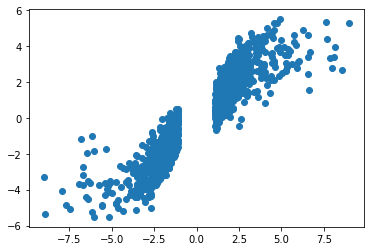

In [44]:
plt.scatter(df['rr'], pred)
plt.show()

In [27]:
# Direct loss
class KernelReisz:
    
    def __init__(self, *, kernel, regl):
        self.kernel = kernel
        self.regl = regl
    
    def fit(self, X):
        # X is [d; w], i.e. first column is d.
        X1 = np.hstack([np.ones((X.shape[0], 1)), X[:, 1:]])
        X0 = np.hstack([np.zeros((X.shape[0], 1)), X[:, 1:]])
        # Calculate K1, K2, K3, K4
        K1 = self.kernel(X)
        K2 = self.kernel(X, X1) - self.kernel(X, X0)
        K3 = self.kernel(X1, X) - self.kernel(X0, X)
        K4 = self.kernel(X1, X1) - self.kernel(X1, X0) - self.kernel(X0, X1) + self.kernel(X0, X0)
        # Expanded kernel matrix
        K = np.block([[K1, K2], [K3, K4]])
        
        # Calculate Delta
        n = X.shape[0]
        Delta = np.block([[K1 @ K1, K1 @ K2], [K3 @ K1, K3 @ K2]]) / n + self.regl * K
        invDelta = np.linalg.pinv(Delta)

        # Calculate V
        V = np.zeros(2 * n)
        V[:n] = (1/n) * np.sum(K2, axis=1)
        V[n:] = (1/n) * np.sum(K4, axis=1)

        # Calculate gamma
        self.gamma = invDelta @ V
        self.Xtrain = X.copy()
        self.X1train = X1.copy()
        self.X0train = X0.copy()
        return self
    
    def predict(self, X):
        # calculate test kernel matrix and predictions
        Ktest1 = kernel(X, self.Xtrain)
        Ktest2 = kernel(X, self.X1train) - kernel(X, self.X0train)
        return np.block([Ktest1, Ktest2]) @ self.gamma

In [38]:
splin = KernelReisz(kernel=kernel, regl=1e-4).fit(X)

In [39]:
pred = splin.predict(Xtest)

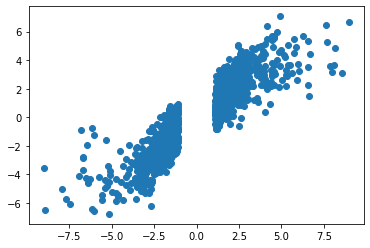

In [40]:
plt.scatter(df['rr'], pred)
plt.show()

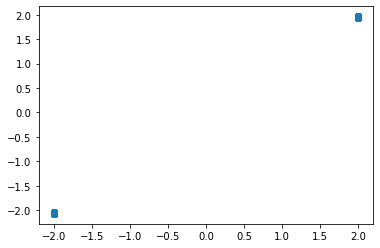

In [19]:
plt.scatter(true_reisz(Xtest, true_propensity), pred)
plt.show()

In [45]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

def cfit_exp(it, splin_fn):
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    a_pred = np.zeros(X.shape[0])
    reg_pred = np.zeros(X.shape[0])
    moment_pred = np.zeros(X.shape[0])
    for train, test in KFold(n_splits=5).split(X):
        splin = splin_fn().fit(X[train])
        a_pred[test] = splin.predict(X[test])
        est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X[train], y[train])
        reg_pred[test] = est.predict(X[test])
        moment_pred[test] = moment_fn(X[test], est.predict)

    return mean_ci(moment_pred + a_pred * (y - reg_pred))

In [46]:
import pandas as pd
from joblib import Parallel, delayed

def exp(it, splin_fn):
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    splin = splin_fn().fit(X)
    a_test = splin.predict(X)
    est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
    return mean_ci(moment_fn(X, est.predict) + a_test * (y - est.predict(X)))

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, pairwise_kernels
import joblib

kernel = lambda X, Y=None: rbf_kernel(X, Y=Y, gamma=.1)

true = 2.2
splin_fn = lambda: AdvKernelReisz(kernel=kernel, regm=6e-5, regl=1e-5)
results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, splin_fn) for it in np.arange(1, 9).astype(int))
joblib.dump(results, 'advreisz_nocfit.jbl')
results = Parallel(n_jobs=-1, verbose=3)(delayed(cfit_exp)(it, splin_fn) for it in np.arange(1, 9).astype(int))
joblib.dump(results, 'advreisz_5fold_cfit.jbl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
splin_fn = lambda: KernelReisz(kernel=kernel, regl=6e-5)
results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, splin_fn) for it in np.arange(1, 9).astype(int))
joblib.dump(results, 'kernelreisz_nocfit.jbl')
results = Parallel(n_jobs=-1, verbose=3)(delayed(cfit_exp)(it, splin_fn) for it in np.arange(1, 9).astype(int))
joblib.dump(results, 'kernelreisz_5fold_cfit.jbl')